In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [0]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
import numpy as np 
import tensorflow as tf


In [0]:
tokenizer = Tokenizer()
!wget --no-check-certificate \
   https://storage.googleapis.com/laurencemoroney-blog.appspot.com/irish-lyrics-eof.txt\
    -O /tmp/irish.txt
data = open('/tmp/irish.txt').read()

corpus = data.lower().split("\n")


tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)


# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

--2020-05-02 05:45:54--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/irish-lyrics-eof.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.218.128, 2a00:1450:4013:c03::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.218.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68970 (67K) [text/plain]
Saving to: ‘/tmp/irish.txt’

/tmp/irish.txt      100%[===================>]  67.35K  --.-KB/s    in 0.001s  

2020-05-02 05:45:54 (89.3 MB/s) - ‘/tmp/irish.txt’ saved [68970/68970]



In [0]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
tf.keras.layers.Bidirectional(tf.keras.layers.GRU(200,return_sequences=True)),
model.add(tf.keras.layers.Conv1D(250, 5, activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(200))
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
#accuracy 0.85, loss 0.61



Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 15, 100)           269000    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 11, 250)           125250    
_________________________________________________________________
dropout_2 (Dropout)          (None, 11, 250)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 200)               360800    
_________________________________________________________________
dense_4 (Dense)              (None, 1345)              270345    
_________________________________________________________________
dense_5 (Dense)              (None, 2690)              3620740   
Total params: 4,646,135
Trainable params: 4,646,135
Non-trainable params: 0
____________________________________________

In [0]:
# Define a Callback class that stops training once accuracy reaches 97.0%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.90):
      print("\nReached 90.0% accuracy so cancelling training!")
      self.model.stop_training = True

In [0]:
 callbacks=myCallback()
 history = model.fit(predictors, label, epochs=500, verbose=1)

Epoch 1/500
377/377 [==============================] - 3s 9ms/step - loss: 6.9264 - accuracy: 0.0639
Epoch 2/500
377/377 [==============================] - 3s 9ms/step - loss: 6.2888 - accuracy: 0.0657
Epoch 3/500
377/377 [==============================] - 3s 9ms/step - loss: 6.0871 - accuracy: 0.0735
Epoch 4/500
377/377 [==============================] - 3s 9ms/step - loss: 5.8743 - accuracy: 0.0837
Epoch 5/500
377/377 [==============================] - 3s 9ms/step - loss: 5.6888 - accuracy: 0.0939
Epoch 6/500
377/377 [==============================] - 3s 9ms/step - loss: 5.5210 - accuracy: 0.1011
Epoch 7/500
377/377 [==============================] - 3s 9ms/step - loss: 5.3675 - accuracy: 0.1132
Epoch 8/500
377/377 [==============================] - 3s 9ms/step - loss: 5.2199 - accuracy: 0.1296
Epoch 9/500
377/377 [==============================] - 3s 9ms/step - loss: 5.0742 - accuracy: 0.1434
Epoch 10/500
377/377 [==============================] - 3s 9ms/step - loss: 4.9411 - accura

In [13]:
!mkdir -p saved_model
model.save('saved_model/my_model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_model/my_model/assets


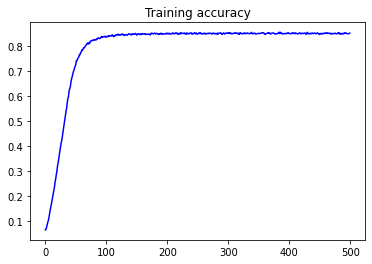

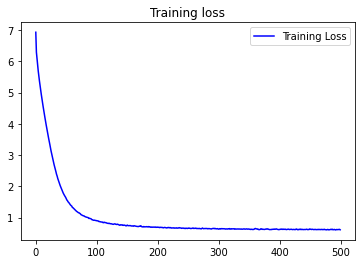

In [14]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [0]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Help me Obi Wan Kenobi, you're my only hope in water when he sails the sea and you love she might little snow thats yearly a bubblin mary he sets oer the sky most bit but shed ever mary in your heart too treasure say thee too fathers way the wild little relations nest forgot forgot so clear years and the blue name so door and down she was their red blaze of freedom for tomorrow and fleet in my flame church seen an delight host of moon does his fate on the daddy o fair song as the rose of lanigans ball or now inside and youth are
